<a href="https://colab.research.google.com/github/homichal3/Recognizing-basketball-offensive-moves/blob/main/last_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB 
from sklearn import svm
from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,plot_confusion_matrix 

In [ ]:
import smtplib
import imghdr
from email.message import EmailMessage

In [ ]:
def acceleration_magnitude(df1):
  i = 1
  new1 = []
  for i in range(len(df1.values[:,2])):
    new1.append(sqrt(df1.values[i,2]**2 + df1.values[i,3]**2 + df1.values[i,4]**2))
  return new1

In [ ]:
def biggest_value_mag(df, width):
  mx = max(df)
  for i in range(len(df)):
    if mx == df[i]:
      index1 = i
    if mx < abs(df[i]):
      mx = abs(df[i])
      index1 = i
  index2 = index1+int((width/2))
  index1 -= int((width/2))
  return index1, index2

In [ ]:
def aritmetic_mean(val):
  return sum(val)/len(val)

In [ ]:
def signal_energy(val):
  val = np.reshape(val,(-1, len(val)))
  p = np.sum(val*val,1)/val.size
  e = p*val.size
  return e

In [ ]:
def get_values_from_movement(mag, list1, signal_ene, mean, labels, label, width):
  index = 0;
  count = 0
  for i in range(len(mag)):
    if i % width == 0 and i > 0:
      list1.append(mag[index:i])
      signal_ene.append(signal_energy(mag[index:i]))
      mean.append(aritmetic_mean(mag[index:i]))
      index = i
      labels.append(label)
      count+=1
    elif count == 20:
      break
  return list1, signal_ene, mean, labels

In [ ]:
def set_values_for_shotting(mag, list1, signal_ene, mean, labels, label, width):
  i, j = biggest_value_mag(mag,width)
  list1.append(mag[i:j])
  signal_ene.append(signal_energy(mag[i:j]))
  mean.append(aritmetic_mean(mag[i:j]))
  labels.append(label)
  return list1, signal_ene, mean, labels

In [ ]:
def data_augmentation_rev(mag, list1, signal_ene, mean, labels, label, width):
  i, j = biggest_value_mag(mag, width)
  new_mag = mag[i:j]
  new_mag = new_mag[::-1]
  list1.append(new_mag)
  signal_ene.append(signal_energy(new_mag))
  mean.append(aritmetic_mean(new_mag))
  labels.append(label)
  return list1, signal_ene, mean, labels

In [ ]:
def data_augmentation_warp(mag, list1, signal_ene, mean, labels, label, value, width):
  i, j = biggest_value_mag(mag, width)
  list1.append(mag[i-value:j-value])
  signal_ene.append(signal_energy(mag[i-value:j-value]))
  mean.append(aritmetic_mean(mag[i-value:j-value]))
  labels.append(label)
  list1.append(mag[i+value:j+value])
  signal_ene.append(signal_energy(mag[i+value:j+value]))
  mean.append(aritmetic_mean(mag[i+value:j+value]))
  labels.append(label)
  return list1, signal_ene, mean, labels

In [ ]:
def data_augmentation_up_down(mag, list1, signal_ene, mean, labels, label, value, width):
  i, j = biggest_value_mag(mag, width)
  temp = mag[i:j]
  temp_incremented = [x+value for x in temp]
  temp_decremented = [x-value for x in temp]

  list1.append(temp_incremented)
  signal_ene.append(signal_energy(temp_incremented))
  mean.append(aritmetic_mean(temp_incremented))
  labels.append(label)

  list1.append(temp_decremented)
  signal_ene.append(signal_energy(temp_decremented))
  mean.append(aritmetic_mean(temp_decremented))
  labels.append(label)
  return list1, signal_ene, mean, labels

In [ ]:
def data_augmentation_scaling(mag, list1, signal_ene, mean, labels, label, value, width):
  i, j = biggest_value_mag(mag, width)
  temp = mag[i:j]
  temp_incremented = [x*value for x in temp]


  list1.append(temp_incremented)
  signal_ene.append(signal_energy(temp_incremented))
  mean.append(aritmetic_mean(temp_incremented))
  labels.append(label)

  return list1, signal_ene, mean, labels

In [ ]:
def get_values_from_movement_gyr(mag, list1, signal_ene, mean, df_gyr, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels, label, width):
  index = 0;
  count = 0
  for i in range(len(mag)):
    if i % width == 0 and i > 0:

      temp = mag[index:i]
      z = df_gyr.values[index:i,2]
      y = df_gyr.values[index:i,3]
      x = df_gyr.values[index:i,4]
      temp.extend(z)
      temp.extend(y)
      temp.extend(x)    

      z_mean_gyr.append(aritmetic_mean(z))
      y_mean_gyr.append(aritmetic_mean(y))
      x_mean_gyr.append(aritmetic_mean(x))

      list1.append(temp)
      signal_ene.append(signal_energy(mag[index:i]))
      mean.append(aritmetic_mean(mag[index:i]))

      index = i
      labels.append(label)
      count+=1
    elif count == 30:
      break
  return list1, signal_ene, mean, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels

In [ ]:
def set_values_for_shotting_gyr(mag, list1, signal_ene,  mean, df_gyr, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels, label, width):
  i, j = biggest_value_mag(mag, width)

  temp = mag[i:j]
  z = df_gyr.values[i:j,2]
  y = df_gyr.values[i:j,3]
  x = df_gyr.values[i:j,4]
  temp.extend(z)
  temp.extend(y)
  temp.extend(x)

  z_mean_gyr.append(aritmetic_mean(df_gyr.values[i:j,2]))
  y_mean_gyr.append(aritmetic_mean(df_gyr.values[i:j,3]))
  x_mean_gyr.append(aritmetic_mean(df_gyr.values[i:j,4]))

  list1.append(temp)
  signal_ene.append(signal_energy(mag[i:j]))
  mean.append(aritmetic_mean(mag[i:j]))
  labels.append(label)
  
  return list1, signal_ene, mean, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels

In [ ]:
def data_augmentation_rev_gyr(mag, list1, signal_ene, mean, df_gyr, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels, label, width):
  i, j = biggest_value_mag(mag, width)
  new_mag = mag[i:j]
  new_mag = new_mag[::-1]
  signal_ene.append(signal_energy(new_mag))
  mean.append(aritmetic_mean(new_mag))

  new_gyr_z = df_gyr.values[i:j,2]
  new_gyr_z = new_gyr_z[::-1]
  new_gyr_y = df_gyr.values[i:j,3]
  new_gyr_y = new_gyr_y[::-1]
  new_gyr_x = df_gyr.values[i:j,4]
  new_gyr_x = new_gyr_x[::-1]


  temp = new_mag
  temp.extend(new_gyr_z)
  temp.extend(new_gyr_y)
  temp.extend(new_gyr_x)

  z_mean_gyr.append(aritmetic_mean(new_gyr_z))
  y_mean_gyr.append(aritmetic_mean(new_gyr_y))
  x_mean_gyr.append(aritmetic_mean(new_gyr_x))

  list1.append(temp)
  labels.append(label)

  return list1, signal_ene, mean, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels

In [ ]:
def data_augmentation_warp_gyr(mag, list1, signal_ene, mean, df_gyr, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels, label, value, width):
  i, j = biggest_value_mag(mag, width)

  temp = mag[i-value:j-value]
  z = df_gyr.values[i-value:j-value,2]
  y = df_gyr.values[i-value:j-value,3]
  x = df_gyr.values[i-value:j-value,4]
  temp.extend(z)
  temp.extend(y)
  temp.extend(x)

  z_mean_gyr.append(aritmetic_mean(df_gyr.values[i-value:j-value,2]))
  y_mean_gyr.append(aritmetic_mean(df_gyr.values[i-value:j-value,3]))
  x_mean_gyr.append(aritmetic_mean(df_gyr.values[i-value:j-value,4]))


  list1.append(temp)
  signal_ene.append(signal_energy(mag[i-value:j-value]))
  mean.append(aritmetic_mean(mag[i-value:j-value]))
  labels.append(label)

  temp = mag[i+value:j+value]
  z = df_gyr.values[i+value:j+value,2]
  y = df_gyr.values[i+value:j+value,3]
  x = df_gyr.values[i+value:j+value,4]
  temp.extend(z)
  temp.extend(y)
  temp.extend(x)

  z_mean_gyr.append(aritmetic_mean(df_gyr.values[i+value:j+value,2]))
  y_mean_gyr.append(aritmetic_mean(df_gyr.values[i+value:j+value,3]))
  x_mean_gyr.append(aritmetic_mean(df_gyr.values[i+value:j+value,4]))

  
  list1.append(temp)
  signal_ene.append(signal_energy(mag[i+value:j+value]))
  mean.append(aritmetic_mean(mag[i+value:j+value]))
  labels.append(label)

  return list1, signal_ene,  mean, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels

In [ ]:
def data_augmentation_scaling_gyr(mag, list1, signal_ene, mean, df_gyr, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels, label, value, width):
  i, j = biggest_value_mag(mag,width)
  temp = mag[i:j]
  temp_scaled = [x*value for x in temp]

  signal_ene.append(signal_energy(temp_scaled))
  mean.append(aritmetic_mean(temp_scaled))

  z = df_gyr.values[i:j,2]
  y = df_gyr.values[i:j,3]
  x = df_gyr.values[i:j,4]
  temp_scaled.extend(z)
  temp_scaled.extend(y)
  temp_scaled.extend(x)

  z_mean_gyr.append(aritmetic_mean(z))
  y_mean_gyr.append(aritmetic_mean(y))
  x_mean_gyr.append(aritmetic_mean(x))

  list1.append(temp_scaled)
  labels.append(label)

  return list1, signal_ene, mean, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels

In [ ]:
def data_augmentation_up_down_gyr(mag, list1, signal_ene, mean, df_gyr, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels, label, value, width):
  i, j = biggest_value_mag(mag,width)
  temp = mag[i:j]
  temp_incremented = [x+value for x in temp]
  temp_decremented = [x-value for x in temp]

  signal_ene.append(signal_energy(temp_incremented))
  mean.append(aritmetic_mean(temp_incremented))

  z = df_gyr.values[i:j,2]
  y = df_gyr.values[i:j,3]
  x = df_gyr.values[i:j,4]
  temp_incremented.extend(z)
  temp_incremented.extend(y)
  temp_incremented.extend(x)

  z_mean_gyr.append(aritmetic_mean(z))
  y_mean_gyr.append(aritmetic_mean(y))
  x_mean_gyr.append(aritmetic_mean(x))

  list1.append(temp_incremented)
  labels.append(label)



  signal_ene.append(signal_energy(temp_decremented))
  mean.append(aritmetic_mean(temp_decremented))

  z = df_gyr.values[i:j,2]
  y = df_gyr.values[i:j,3]
  x = df_gyr.values[i:j,4]
  temp_decremented.extend(z)
  temp_decremented.extend(y)
  temp_decremented.extend(x)

  z_mean_gyr.append(aritmetic_mean(z))
  y_mean_gyr.append(aritmetic_mean(y))
  x_mean_gyr.append(aritmetic_mean(x))

  list1.append(temp_decremented)
  labels.append(label)
  return list1, signal_ene, mean, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels

In [ ]:
def get_indexes(mag, labels, width):
  temp_mag = mag
  zeros = np.zeros(width)
  indexes = []
  iter = len(labels)
  width = int((width)/2)

  while iter != 0:
    mx = max(temp_mag)
    for i in range(len(temp_mag)):
      if(mx == mag[i]):
        indexes.append(i)
        temp_mag[i-width:i+width] = zeros
        iter -= 1
        break
  return indexes

In [ ]:
def set_labels(labels, indexes):
  j = 0
  iter = len(labels)
  new_label = np.zeros(len(labels))
  while iter != 0:
    mini = min(indexes)
    for i in range(len(indexes)):
      if mini == indexes[i]:
        new_label[i] = labels[j]
        j += 1
        indexes[i] = 100000000000
        iter -= 1
  zeros = np.zeros(int(len(labels)/2))
  ones = np.ones(int(len(labels)/2))
  new_label = np.concatenate((new_label, zeros, ones))
  return new_label

In [ ]:
def cutting_chart_to_pieces(mag, list1, mean, signal_ene, labels, labels_new, width):
  iter = len(labels_new)
  width = int((width)/2)
  while iter != 0:
    mx = max(mag)
    if iter > int(len(labels_new)/4):
      for i in range(len(mag)):
        if mx == mag[i]:
          list1.append(mag[i-width:i+width])
          mean.append(aritmetic_mean(mag[i-width:i+width]))
          signal_ene.append(signal_energy(mag[i-width:i+width]))
          del mag[i-width:i+width]
          iter -= 1
          break
    elif iter <= int(len(labels_new)/4):
      for i in range(len(mag)):
        mn = min(mag)
        if mn == mag[i]:
          list1.append(mag[i-width:i+width])
          mean.append(aritmetic_mean(mag[i-width:i+width]))
          signal_ene.append(signal_energy(mag[i-width:i+width]))
          del mag[i-width:i+width]
          iter -= 1
          break

  labels = np.concatenate((labels,labels_new))
  return list1, mean, signal_ene, labels 

In [ ]:
def cutting_chart_to_pieces_gyr(mag, list1, mean, signal_ene, df_gyr, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels, labels_new, width):
  iter = len(labels_new)
  z = df_gyr.values[:,2]
  y = df_gyr.values[:,3]
  x = df_gyr.values[:,4]
  z = z.tolist()
  y = y.tolist()
  x = x.tolist()

  width = int((width)/2)

  while iter != 0 :
    if iter > int(len(labels_new)/4):
      mx = max(mag)
      for i in range(len(mag)):
        if mx == mag[i] :
          mean.append(aritmetic_mean(mag[i-width:i+width]))
          signal_ene.append(signal_energy(mag[i-width:i+width]))

          temp = mag[i-width:i+width]

          temp.extend(z[i-width:i+width])
          temp.extend(y[i-width:i+width])
          temp.extend(x[i-width:i+width])    


          z_mean_gyr.append(aritmetic_mean(z[i-width:i+width]))
          y_mean_gyr.append(aritmetic_mean(y[i-width:i+width]))
          x_mean_gyr.append(aritmetic_mean(x[i-width:i+width]))

          list1.append(temp)


          del z[i-width:i+width]
          del y[i-width:i+width]
          del x[i-width:i+width]
          del mag[i-width:i+width]
          iter -= 1
          break


    elif iter <= int(len(labels_new)/4):
      for i in range(len(mag)):
        mn = min(mag)
        if mn == mag[i]:

          mean.append(aritmetic_mean(mag[i-width:i+width]))
          signal_ene.append(signal_energy(mag[i-width:i+width]))

          temp = mag[i-width:i+width]
          temp.extend(z[i-width:i+width])
          temp.extend(y[i-width:i+width])
          temp.extend(x[i-width:i+width])    

          z_mean_gyr.append(aritmetic_mean(z[i-width:i+width]))
          y_mean_gyr.append(aritmetic_mean(y[i-width:i+width]))
          x_mean_gyr.append(aritmetic_mean(x[i-width:i+width]))

          list1.append(temp)

          del z[i-width:i+width]
          del y[i-width:i+width]
          del x[i-width:i+width]
          del mag[i-width:i+width]
          iter -= 1
          break

  labels = np.concatenate((labels,labels_new))
  return list1, mean, signal_ene, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels 

In [ ]:
!cp /content/drive/MyDrive/Database.zip .
!unzip Database.zip

Archive:  Database.zip
   creating: Database_draft/
   creating: Database_draft/R1F/
  inflating: Database_draft/R1F/R01F.csv  
  inflating: Database_draft/R1F/R02F.csv  
  inflating: Database_draft/R1F/R04F.csv  
  inflating: Database_draft/R1F/R05F.csv  
  inflating: Database_draft/R1F/R06F.csv  
  inflating: Database_draft/R1F/R07F.csv  
  inflating: Database_draft/R1F/R08F.csv  
  inflating: Database_draft/R1F/R03F.csv  
  inflating: Database_draft/R1F/R09F.csv  
  inflating: Database_draft/R1F/R10F.csv  
  inflating: Database_draft/R1F/R11F.csv  
  inflating: Database_draft/R1F/R12F.csv  
  inflating: Database_draft/R1F/R13F.csv  
  inflating: Database_draft/R1F/R14F.csv  
  inflating: Database_draft/R1F/R15F.csv  
   creating: Database_draft/KOZIOL/
  inflating: Database_draft/KOZIOL/koziol.csv  
   creating: Database_draft/KOZIOL_TRUCHT_BIEG/
  inflating: Database_draft/KOZIOL_TRUCHT_BIEG/koziol_trucht_bieg.csv  
   creating: Database_draft/R1T/
  inflating: Database_draft/R1T/R

In [ ]:
!cp /content/drive/MyDrive/Database_acc_gyr.zip .
!unzip Database_acc_gyr.zip 

Archive:  Database_acc_gyr.zip
   creating: Database_acc_gyr/
   creating: Database_acc_gyr/R1F/
   creating: Database_acc_gyr/R1F/R01F/
  inflating: Database_acc_gyr/R1F/R01F/Accelerometer.csv  
  inflating: Database_acc_gyr/R1F/R01F/Gyroscope.csv  
   creating: Database_acc_gyr/R1F/R02F/
  inflating: Database_acc_gyr/R1F/R02F/Accelerometer.csv  
  inflating: Database_acc_gyr/R1F/R02F/Gyroscope.csv  
   creating: Database_acc_gyr/R1F/R03F/
  inflating: Database_acc_gyr/R1F/R03F/Accelerometer.csv  
  inflating: Database_acc_gyr/R1F/R03F/Gyroscope.csv  
   creating: Database_acc_gyr/R1F/R04F/
  inflating: Database_acc_gyr/R1F/R04F/Accelerometer.csv  
  inflating: Database_acc_gyr/R1F/R04F/Gyroscope.csv  
   creating: Database_acc_gyr/R1F/R05F/
  inflating: Database_acc_gyr/R1F/R05F/Accelerometer.csv  
  inflating: Database_acc_gyr/R1F/R05F/Gyroscope.csv  
   creating: Database_acc_gyr/R1F/R06F/
  inflating: Database_acc_gyr/R1F/R06F/Accelerometer.csv  
  inflating: Database_acc_gyr/R1F/

In [ ]:
def accelerometer_algorithm_act(width, warp, value_for_warp, reverse, up_down, value_for_up_down, scaling,value_for_scaling, new_labels_1):
  #Data classification
  MAIN_DIRPATH = '/content/Database_draft/'

  labels = []
  signal_ene = []
  mean = []
  data =[]

  
  for dir in os.listdir(MAIN_DIRPATH):
    if dir == 'KOZIOL':
      label = 0
    elif dir == 'KOZIOL_TRUCHT_BIEG':
      label = 0
    elif dir == 'TRUCHT_BIEG':
      label = 1
    elif dir == 'R1F':
      label = 2
    elif dir == 'R1T':
      label = 3
    elif dir == 'R2F':
      label = 4
    elif dir == 'R2T':
      label = 5
    elif dir == 'R3F':
      label = 6
    elif dir == 'R3T':
      label = 7
    for file in os.listdir((MAIN_DIRPATH)+dir):
      df = pd.read_csv(MAIN_DIRPATH+dir+'/'+file)
      acc_mag = acceleration_magnitude(df)
      if label <= 2:
        data, signal_ene, mean, labels = get_values_from_movement(acc_mag, data, signal_ene, mean, labels, label, width)
        break
      else:
        data, signal_ene, mean, labels = set_values_for_shotting(acc_mag, data, signal_ene, mean, labels, label, width)
        if reverse:
          data, signal_ene, mean, labels = data_augmentation_rev(acc_mag, data, signal_ene, mean, labels, label, width)
        if warp:
          data, signal_ene, mean, labels = data_augmentation_warp(acc_mag, data, signal_ene, mean, labels, label, value_for_warp, width)
        if value_for_up_down:
          data, signal_ene, mean, labels = data_augmentation_up_down(acc_mag, data, signal_ene, mean, labels, label, value_for_up_down, width)
        if scaling:
          data, signal_ene, mean, labels = data_augmentation_scaling(acc_mag, data, signal_ene, mean, labels, label, value_for_scaling, width)


  df = pd.read_csv('Accelerometer.csv')
  df_gyro = pd.read_csv('Gyroscope.csv')
  ts = pd.to_datetime(df['time'], unit = 'ns')
  ts = ts - ts[0]
  mag_t = acceleration_magnitude(df)
  indexes = get_indexes(mag_t, new_labels_1, width)
  new_labels = set_labels(new_labels_1, indexes)
  mag_t = acceleration_magnitude(df)
  data, mean, signal_ene, labels = cutting_chart_to_pieces(mag_t, data ,mean, signal_ene, labels, new_labels, width)


  df = pd.DataFrame(data)
  df["signal energy"] = signal_ene
  df["mean"] = mean
  df["labels"] = labels


  df.info()

  columns = df.columns
  x_columns = columns[:-1]
  y_columns = columns[-1]

  # NORMALIZACJA
  for column in x_columns:
      max_v, min_v = df[column].max(), df[column].min()
      values = df[column].tolist()
      normalized_values = []
      for el in values:
          try:
              el = float(el)
              el_n = (el-min_v)/(max_v-min_v) # Tu byl blad
              normalized_values.append(el_n)
          except:
              print("znaleziono daną która nie jest liczbą! Zastąpie ją zerem")
              el_n = 0
      df[column] = np.array(normalized_values)
      
  print("PO NORMALIZACJI")
  print(df)


  y = df[y_columns]
  X = df[x_columns]

  
  length = 2*len(new_labels_1)
  X_train = X[:len(X)-length]
  y_train = y[:len(X)-length]
  X_test = X[len(X)-length:]
  y_test = y[len(y)-length:]
    

  # DEFINE
  gnb = GaussianNB()
  clf = svm.SVC()
  clf_tree = tree.DecisionTreeClassifier()
  clf_forest = RandomForestClassifier(max_depth=2, random_state=0)


  # TRAIN CLASSIFIERS
  gnb.fit(X_train, y_train)
  clf.fit(X_train, y_train)
  clf_tree.fit(X_train, y_train)
  clf_forest.fit(X_train, y_train)


  #PREDICTIONS
  y_preds_naive = gnb.predict(X_test)
  y_preds_svm = clf.predict(X_test)
  y_preds_tree = clf_tree.predict(X_test)
  y_preds_forest = clf_forest.predict(X_test)


  #ACCURACY
  acc_naive_bayes = accuracy_score(y_test, y_preds_naive)
  acc_svm = accuracy_score(y_test, y_preds_svm)
  acc_tree = accuracy_score(y_test, y_preds_tree)
  acc_forest = accuracy_score(y_test, y_preds_forest)

  # PRINT RESULTS

  print("ACCURACY")
  print(f"Naive bayes: {acc_naive_bayes}")
  print(f"SVM VECTORS: {acc_svm}")
  print(f"DECISION TREE: {acc_tree}")
  print(f"RANDOM FOREST: {acc_forest}")

  confusion_matrix_labels = ['K/KTB','TB','R1F','R1T','R2F','R2T','R3F','R3T']

  plot_confusion_matrix(gnb, X_test, y_test, display_labels = confusion_matrix_labels, xticks_rotation='vertical')
  plt.savefig('confussion_matrix_naive_acc_act.png')
  plt.show()

  plot_confusion_matrix(clf, X_test, y_test, display_labels = confusion_matrix_labels, xticks_rotation='vertical')
  plt.savefig('confussion_matrix_svm_acc_act.png')
  plt.show()

  plot_confusion_matrix(clf_tree, X_test, y_test, display_labels = confusion_matrix_labels, xticks_rotation='vertical')
  plt.savefig('confussion_matrix_decision_tree_acc_act.png')
  plt.show()

  plot_confusion_matrix(clf_forest, X_test, y_test, display_labels = confusion_matrix_labels, xticks_rotation='vertical')
  plt.savefig('confussion_matrix_random_tree_acc_act.png')
  plt.show()


  MAIN_DIRPATH = '/content/Database_acc_gyr/'

  labels1 = []
  signal_ene1 = []
  mean1 = []
  z_mean_gyr = []
  y_mean_gyr = []
  x_mean_gyr = []
  data1 =[]

  temp = 0

  for dir in os.listdir(MAIN_DIRPATH):
    if dir == 'KOZIOL':
      label = 0
    elif dir == 'KOZIOL_TRUCHT_BIEG':
      label = 0
    elif dir == 'TRUCHT_BIEG':
      label = 1
    elif dir == 'R1F':
      label = 2
    elif dir == 'R1T':
      label = 3
    elif dir == 'R2F':
      label = 4
    elif dir == 'R2T':
      label = 5
    elif dir == 'R3F':
      label = 6
    elif dir == 'R3T':
      label = 7
    for dir1 in os.listdir((MAIN_DIRPATH)+dir):
      for file in os.listdir(((MAIN_DIRPATH)+dir+'/')+dir1):
        if 'Gyro' in (MAIN_DIRPATH+dir+'/'+dir1 +'/'+file):
          df_gyr = pd.read_csv(MAIN_DIRPATH+dir+'/'+dir1 +'/'+file)
          temp +=1
        elif 'Acc' in (MAIN_DIRPATH+dir+'/'+dir1 +'/'+file):
          df = pd.read_csv(MAIN_DIRPATH+dir+'/'+dir1 +'/'+file)
          acc_mag = acceleration_magnitude(df)
          temp +=1
        if temp == 2:
          if label <= 2:
            data1, signal_ene1, mean1, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1 = get_values_from_movement_gyr(acc_mag, data1, signal_ene1, mean1, df_gyr, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1, label, width)
            temp = 0
            break
          else:
            data1, signal_ene1, mean1, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1 = set_values_for_shotting_gyr(acc_mag, data1, signal_ene1, mean1, df_gyr, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1, label, width)
            if reverse:
              data1, signal_ene1, mean1, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1 = data_augmentation_rev_gyr(acc_mag, data1, signal_ene1, mean1, df_gyr, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1, label, width)
            if warp:
              data1, signal_ene1, mean1, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1 = data_augmentation_warp_gyr(acc_mag, data1, signal_ene1, mean1, df_gyr, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1, label, value_for_warp, width)
            if up_down:
              data1, signal_ene1, mean1, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1 = data_augmentation_up_down_gyr(acc_mag, data1, signal_ene1, mean1, df_gyr, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1, label, value_for_up_down, width)
            if scaling:
              data1, signal_ene1, mean1, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1 = data_augmentation_scaling_gyr(acc_mag, data1, signal_ene1, mean1, df_gyr, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1, label, value_for_scaling, width)
            temp = 0  

  df_3t = pd.read_csv('Accelerometer.csv')
  df_gyro = pd.read_csv('Gyroscope.csv')
  ts_3t = pd.to_datetime(df_3t['time'], unit = 'ns')
  ts_3t = ts_3t - ts_3t[0]
  mag_t = acceleration_magnitude(df_3t)
  indexes = get_indexes(mag_t, new_labels_1,width)
  new_labels = set_labels(new_labels_1, indexes)
  mag_t = acceleration_magnitude(df_3t)
  data1, mean1, signal_ene1, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1 = cutting_chart_to_pieces_gyr(mag_t, data1 ,mean1, signal_ene1, df_gyro, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1, new_labels, width)


  df = pd.DataFrame(data1)
  df["signal energy"] = signal_ene1
  df["mean"] = mean1
  df["y axis gyroscope mean"] = z_mean_gyr
  df["z axis gyroscope mean"] = y_mean_gyr
  df["x axis gyroscope mean"] = x_mean_gyr
  df["labels"] = labels1

  columns = df.columns
  x_columns = columns[:-1]
  y_columns = columns[-1]
  
  df.info()

  # NORMALIZACJA
  for column in x_columns:
      max_v, min_v = df[column].max(), df[column].min()
      values = df[column].tolist()
      normalized_values = []
      for el in values:
          try:
              el = float(el)
              el_n = (el-min_v)/(max_v-min_v) # Tu byl blad
              normalized_values.append(el_n)
          except:
              print("znaleziono daną która nie jest liczbą! Zastąpie ją zerem")
              el_n = 0
      df[column] = np.array(normalized_values)
      
      
  print("PO NORMALIZACJI")
  print(df)


  tmp = 0.3
  #split data to test and train datasets
  y = df[y_columns]
  X = df[x_columns]


  X_train = X[:len(X)-len(new_labels)]
  y_train = y[:len(X)-len(new_labels)]
  X_test = X[len(X)-len(new_labels):]
  y_test = y[len(y)-len(new_labels):]

  # DEFINE
  gnb = GaussianNB()
  clf = svm.SVC()
  clf_tree = tree.DecisionTreeClassifier()
  clf_forest = RandomForestClassifier(max_depth=2, random_state=0)


  # TRAIN CLASSIFIERS
  gnb.fit(X_train, y_train)
  clf.fit(X_train, y_train)
  clf_tree.fit(X_train, y_train)
  clf_forest.fit(X_train, y_train)


  #PREDICTIONS
  y_preds_naive = gnb.predict(X_test)
  y_preds_svm = clf.predict(X_test)
  y_preds_tree = clf_tree.predict(X_test)
  y_preds_forest = clf_forest.predict(X_test)


  #ACCURACY
  acc_naive_bayes_1 = accuracy_score(y_test, y_preds_naive)
  acc_svm_1 = accuracy_score(y_test, y_preds_svm)
  acc_tree_1 = accuracy_score(y_test, y_preds_tree)
  acc_forest_1 = accuracy_score(y_test, y_preds_forest)

  # PRINT RESULTS

  print("ACCURACY")
  print(f"Naive bayes: {acc_naive_bayes_1}")
  print(f"SVM VECTORS: {acc_svm_1}")
  print(f"DECISION TREE: {acc_tree_1}")
  print(f"RANDOM FOREST: {acc_forest_1}")
  
  confusion_matrix_labels = ['K/KTB','TB','R1F','R1T','R2F','R2T','R3F','R3T']

  plot_confusion_matrix(gnb, X_test, y_test, display_labels = confusion_matrix_labels, xticks_rotation='vertical')
  plt.savefig('confussion_matrix_naive_gyr_act.png')
  plt.show()

  plot_confusion_matrix(clf, X_test, y_test, display_labels = confusion_matrix_labels, xticks_rotation='vertical')
  plt.savefig('confussion_matrix_svm_gyr_act.png')
  plt.show()

  plot_confusion_matrix(clf_tree, X_test, y_test, display_labels = confusion_matrix_labels, xticks_rotation='vertical')
  plt.savefig('confussion_matrix_decision_tree_gyr_act.png')
  plt.show()

  plot_confusion_matrix(clf_forest, X_test, y_test, display_labels = confusion_matrix_labels, xticks_rotation='vertical')
  plt.savefig('confussion_matrix_random_tree_gyr_act.png')
  plt.show()


  Sender_Email = "hojmich@gmail.com"
  Reciever_Email = "hojmich@gmail.com"
  
  Password = input('Enter your email account password: ')

  newMessage = EmailMessage()                         
  newMessage['Subject'] = "Result:" 
  newMessage['From'] = Sender_Email                   
  newMessage['To'] = Reciever_Email                   
  newMessage.set_content('The accuracy of the obtained results is as follows:\n'
  + '====Acccelerometer====                 ======Gyroscope and Accelerometer=====\n'
  + '=====ACCURACY=====                  ============ACCURACY============\n'
  + f"Naive bayes: {round(acc_naive_bayes,2)}                              Naive bayes: {round(acc_naive_bayes_1,2)}\n"
  + f"SVM vectors: {round(acc_svm,2)}                              SVM vectors: {round(acc_svm_1,2)}\n"
  + f"Decision tree: {round(acc_tree,2)}                              Decision tree: {round(acc_tree_1,2)}\n"
  + f"Random forest: {round(acc_forest,2)}                          Random forest: {round(acc_forest_1,2)}\n"
  + "==============================================================\n"
  + "K - Dribbling \nKTB - Dribbling while running \nTB - trucht lub bieg \nR1F - 1-point field goals missed \nR1T - 1-point field goals made \nR2F - 2-point field goals missed \nR2T - 2-point field goals made \nR3F - 3-point field goals missed \nR3T - 3-point field goals made")

  files = ['confussion_matrix_naive_acc_act.png',  'confussion_matrix_svm_acc_act.png', 'confussion_matrix_random_tree_acc_act.png', 'confussion_matrix_decision_tree_acc_act.png', 'confussion_matrix_naive_gyr_act.png',  'confussion_matrix_svm_gyr_act.png', 'confussion_matrix_random_tree_gyr_act.png', 'confussion_matrix_decision_tree_gyr_act.png']

  for file in files:
    with open(file, 'rb') as f:
      image_data = f.read()
      image_type = imghdr.what(f.name)
      image_name = f.name
    newMessage.add_attachment(image_data, maintype = 'image', subtype = image_type, filename = image_name)

  with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
      
      smtp.login(Sender_Email, Password)              
      smtp.send_message(newMessage)

In [ ]:
def accelerometer_algorithm(width, warp, value_for_warp, reverse, up_down, value_for_up_down, scaling, value_for_scaling):
  #Data classification
  MAIN_DIRPATH = '/content/Database_draft/'

  labels = []
  signal_ene = []
  mean = []
  data =[]

  
  for dir in os.listdir(MAIN_DIRPATH):
    if dir == 'KOZIOL':
      label = 0
    elif dir == 'KOZIOL_TRUCHT_BIEG':
      label = 0
    elif dir == 'TRUCHT_BIEG':
      label = 1
    elif dir == 'R1F':
      label = 2
    elif dir == 'R1T':
      label = 3
    elif dir == 'R2F':
      label = 4
    elif dir == 'R2T':
      label = 5
    elif dir == 'R3F':
      label = 6
    elif dir == 'R3T':
      label = 7
    for file in os.listdir((MAIN_DIRPATH)+dir):
      df = pd.read_csv(MAIN_DIRPATH+dir+'/'+file)
      acc_mag = acceleration_magnitude(df)
      if label <= 1:
        data, signal_ene, mean, labels = get_values_from_movement(acc_mag, data, signal_ene, mean, labels, label, width)
        break
      else:
        data, signal_ene, mean, labels = set_values_for_shotting(acc_mag, data, signal_ene, mean, labels, label, width)
        if reverse:
          data, signal_ene, mean, labels = data_augmentation_rev(acc_mag, data, signal_ene, mean, labels, label, width)
        if warp:
          data, signal_ene, mean, labels = data_augmentation_warp(acc_mag, data, signal_ene, mean, labels, label, value_for_warp, width)
        if value_for_up_down:
          data, signal_ene, mean, labels = data_augmentation_up_down(acc_mag, data, signal_ene, mean, labels, label, value_for_up_down, width)
        if scaling:
          data, signal_ene, mean, labels = data_augmentation_scaling(acc_mag, data, signal_ene, mean, labels, label, value_for_scaling, width)


  df = pd.DataFrame(data)
  df["signal energy"] = signal_ene
  df["mean"] = mean
  df["labels"] = labels


  columns = df.columns
  x_columns = columns[:-1]
  y_columns = columns[-1]

  df.info()
  print(df)

  # NORMALIZACJA
  for column in x_columns:
      max_v, min_v = df[column].max(), df[column].min()
      values = df[column].tolist()
      normalized_values = []
      for el in values:
          try:
              el = float(el)
              el_n = (el-min_v)/(max_v-min_v) # Tu byl blad
              normalized_values.append(el_n)
          except:
              print("znaleziono daną która nie jest liczbą! Zastąpie ją zerem")
              el_n = 0
      df[column] = np.array(normalized_values)
      
  print("PO NORMALIZACJI")

  tmp = 0.3
  y = df[y_columns]
  X = df[x_columns]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tmp, random_state=42)
    

  # DEFINE
  gnb = GaussianNB()
  clf = svm.SVC()
  clf_tree = tree.DecisionTreeClassifier()
  clf_forest = RandomForestClassifier(max_depth=2, random_state=0)


  # TRAIN CLASSIFIERS
  gnb.fit(X_train, y_train)
  clf.fit(X_train, y_train)
  clf_tree.fit(X_train, y_train)
  clf_forest.fit(X_train, y_train)


  #PREDICTIONS
  y_preds_naive = gnb.predict(X_test)
  y_preds_svm = clf.predict(X_test)
  y_preds_tree = clf_tree.predict(X_test)
  y_preds_forest = clf_forest.predict(X_test)


  #ACCURACY
  acc_naive_bayes = accuracy_score(y_test, y_preds_naive)
  acc_svm = accuracy_score(y_test, y_preds_svm)
  acc_tree = accuracy_score(y_test, y_preds_tree)
  acc_forest = accuracy_score(y_test, y_preds_forest)

  # PRINT RESULTS

  print("ACCURACY")
  print(f"Naive bayes: {acc_naive_bayes}")
  print(f"SVM VECTORS: {acc_svm}")
  print(f"DECISION TREE: {acc_tree}")
  print(f"RANDOM FOREST: {acc_forest}")


  confusion_matrix_labels = ['K/KTB','TB','R1F','R1T','R2F','R2T','R3F','R3T']

  plot_confusion_matrix(gnb, X_test, y_test, display_labels = confusion_matrix_labels, xticks_rotation='vertical')
  plt.savefig('confussion_matrix_naive_acc.png')
  plt.show()

  plot_confusion_matrix(clf, X_test, y_test, display_labels = confusion_matrix_labels, xticks_rotation='vertical')
  plt.savefig('confussion_matrix_svm_acc.png')
  plt.show()

  plot_confusion_matrix(clf_tree, X_test, y_test, display_labels = confusion_matrix_labels, xticks_rotation='vertical')
  plt.savefig('confussion_matrix_decision_tree_acc.png')
  plt.show()

  plot_confusion_matrix(clf_forest, X_test, y_test, display_labels = confusion_matrix_labels, xticks_rotation='vertical')
  plt.savefig('confussion_matrix_random_tree_acc.png')
  plt.show()

  print("gyroscope")

  MAIN_DIRPATH = '/content/Database_acc_gyr/'

  labels1 = []
  signal_ene1 = []
  mean1 = []
  z_mean_gyr = []
  y_mean_gyr = []
  x_mean_gyr = []
  data1 =[]

  temp = 0


  for dir in os.listdir(MAIN_DIRPATH):
    if dir == 'KOZIOL':
      label = 0
    elif dir == 'KOZIOL_TRUCHT_BIEG':
      label = 0
    elif dir == 'TRUCHT_BIEG':
      label = 1
    elif dir == 'R1F':
      label = 2
    elif dir == 'R1T':
      label = 3
    elif dir == 'R2F':
      label = 4
    elif dir == 'R2T':
      label = 5
    elif dir == 'R3F':
      label = 6
    elif dir == 'R3T':
      label = 7
    for dir1 in os.listdir((MAIN_DIRPATH)+dir):
      for file in os.listdir(((MAIN_DIRPATH)+dir+'/')+dir1):
        if 'Gyro' in (MAIN_DIRPATH+dir+'/'+dir1 +'/'+file):
          df_gyr = pd.read_csv(MAIN_DIRPATH+dir+'/'+dir1 +'/'+file)
          temp +=1
        elif 'Acc' in (MAIN_DIRPATH+dir+'/'+dir1 +'/'+file):
          df = pd.read_csv(MAIN_DIRPATH+dir+'/'+dir1 +'/'+file)
          acc_mag = acceleration_magnitude(df)
          temp +=1
        if temp == 2:
          if label <= 1:
            data1, signal_ene1, mean1, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1 = get_values_from_movement_gyr(acc_mag, data1, signal_ene1, mean1, df_gyr, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1, label, width)
            temp = 0
            break
          else:
            data1, signal_ene1, mean1, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1 = set_values_for_shotting_gyr(acc_mag, data1, signal_ene1, mean1, df_gyr, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1, label, width)
            if reverse:
              data1, signal_ene1, mean1, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1 = data_augmentation_rev_gyr(acc_mag, data1, signal_ene1, mean1, df_gyr, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1, label, width)
            if warp:
              data1, signal_ene1, mean1, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1 = data_augmentation_warp_gyr(acc_mag, data1, signal_ene1, mean1, df_gyr, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1, label, value_for_warp, width)
            if up_down:
              data1, signal_ene1, mean1, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1 = data_augmentation_up_down_gyr(acc_mag, data1, signal_ene1, mean1, df_gyr, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1, label, value_for_up_down, width)
            if scaling:
              data1, signal_ene1, mean1, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1 = data_augmentation_scaling_gyr(acc_mag, data1, signal_ene1, mean1, df_gyr, z_mean_gyr, y_mean_gyr, x_mean_gyr, labels1, label, value_for_scaling, width)
            temp = 0  


  df_1 = pd.DataFrame(data1)
  df_1["signal energy"] = signal_ene1
  df_1["mean"] = mean1
  df_1["y axis gyr mean"] = z_mean_gyr
  df_1["z axis gyr mean"] = y_mean_gyr
  df_1["x axis gyr mean"] = x_mean_gyr
  df_1["labels"] = labels1


  columns = df_1.columns
  x_columns = columns[:-1]
  y_columns = columns[-1]

  df_1.info()
  print(df_1)
  
  # NORMALIZACJA
  for column in x_columns:
      max_v, min_v = df_1[column].max(), df_1[column].min()
      values = df_1[column].tolist()
      normalized_values = []
      for el in values:
          try:
              el = float(el)
              el_n = (el-min_v)/(max_v-min_v) # Tu byl blad
              normalized_values.append(el_n)
          except:
              print("znaleziono daną która nie jest liczbą! Zastąpie ją zerem")
              el_n = 0
      df_1[column] = np.array(normalized_values)
      
      
  print("PO NORMALIZACJI")


  tmp = 0.3
  #split data to test and train datasets
  y = df_1[y_columns]
  X = df_1[x_columns]


  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tmp, random_state=42)

  # DEFINE
  gnb = GaussianNB()
  clf = svm.SVC()
  clf_tree = tree.DecisionTreeClassifier()
  clf_forest = RandomForestClassifier(max_depth=2, random_state=0)


  # TRAIN CLASSIFIERS
  gnb.fit(X_train, y_train)
  clf.fit(X_train, y_train)
  clf_tree.fit(X_train, y_train)
  clf_forest.fit(X_train, y_train)


  #PREDICTIONS
  y_preds_naive = gnb.predict(X_test)
  y_preds_svm = clf.predict(X_test)
  y_preds_tree = clf_tree.predict(X_test)
  y_preds_forest = clf_forest.predict(X_test)


  #ACCURACY
  acc_naive_bayes_1 = accuracy_score(y_test, y_preds_naive)
  acc_svm_1 = accuracy_score(y_test, y_preds_svm)
  acc_tree_1 = accuracy_score(y_test, y_preds_tree)
  acc_forest_1 = accuracy_score(y_test, y_preds_forest)

  # PRINT RESULTS

  print("ACCURACY")
  print(f"Naive bayes: {acc_naive_bayes_1}")
  print(f"SVM VECTORS: {acc_svm_1}")
  print(f"DECISION TREE: {acc_tree_1}")
  print(f"RANDOM FOREST: {acc_forest_1}")


  confusion_matrix_labels = ['K/KTB','TB','R1F','R1T','R2F','R2T','R3F','R3T']

  plot_confusion_matrix(gnb, X_test, y_test, display_labels = confusion_matrix_labels, xticks_rotation='vertical')
  plt.savefig('confussion_matrix_naive_acc_gyr.png')
  plt.show()

  plot_confusion_matrix(clf, X_test, y_test, display_labels = confusion_matrix_labels, xticks_rotation='vertical')
  plt.savefig('confussion_matrix_svm_acc_gyr.png')
  plt.show()

  plot_confusion_matrix(clf_tree, X_test, y_test, display_labels = confusion_matrix_labels, xticks_rotation='vertical')
  plt.savefig('confussion_matrix_decision_tree_acc_gyr.png')
  plt.show()

  plot_confusion_matrix(clf_forest, X_test, y_test, display_labels = confusion_matrix_labels, xticks_rotation='vertical')
  plt.savefig('confussion_matrix_random_tree_acc_gyr.png')
  plt.show()

  Sender_Email = "hojmich@gmail.com"
  Reciever_Email = "hojmich@gmail.com"
  
  Password = input('Enter your email account password: ')

  newMessage = EmailMessage()                         
  newMessage['Subject'] = "Result:" 
  newMessage['From'] = Sender_Email                   
  newMessage['To'] = Reciever_Email                   
  newMessage.set_content('The accuracy of the obtained results is as follows:\n'
  + '====Acccelerometer====                  =====Gyroscope and Accelerometer=====\n'
  + '=====ACCURACY=====                 =============ACCURACY=============\n'
  + f"Naive bayes: {round(acc_naive_bayes,2)}                              Naive bayes: {round(acc_naive_bayes_1,2)}\n"
  + f"SVM vectors: {round(acc_svm,2)}                               SVM vectors: {round(acc_svm_1,2)}\n"
  + f"Decision tree: {round(acc_tree,2)}                               Decision tree: {round(acc_tree_1,2)}\n"
  + f"Random forest: {round(acc_forest,2)}                           Random forest: {round(acc_forest_1,2)}\n"
  + "==============================================================\n"
  + "K - Dribbling \nKTB - Dribbling while running \nTB - trucht lub bieg \nR1F - 1-point field goals missed \nR1T - 1-point field goals made \nR2F - 2-point field goals missed \nR2T - 2-point field goals made \nR3F - 3-point field goals missed \nR3T - 3-point field goals made")

  files = ['confussion_matrix_naive_acc.png',  'confussion_matrix_svm_acc.png', 'confussion_matrix_random_tree_acc.png', 'confussion_matrix_decision_tree_acc.png', 'confussion_matrix_naive_acc_gyr.png',  'confussion_matrix_svm_acc_gyr.png', 'confussion_matrix_random_tree_acc_gyr.png', 'confussion_matrix_decision_tree_acc_gyr.png']

  for file in files:
    with open(file, 'rb') as f:
      image_data = f.read()
      image_type = imghdr.what(f.name)
      image_name = f.name
    newMessage.add_attachment(image_data, maintype = 'image', subtype = image_type, filename = image_name)

  with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
      
      smtp.login(Sender_Email, Password)              
      smtp.send_message(newMessage)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   0              150 non-null    float64
 1   1              150 non-null    float64
 2   2              150 non-null    float64
 3   3              150 non-null    float64
 4   4              150 non-null    float64
 5   5              150 non-null    float64
 6   6              150 non-null    float64
 7   7              150 non-null    float64
 8   8              150 non-null    float64
 9   9              150 non-null    float64
 10  10             150 non-null    float64
 11  11             150 non-null    float64
 12  12             150 non-null    float64
 13  13             150 non-null    float64
 14  14             150 non-null    float64
 15  15             150 non-null    float64
 16  16             150 non-null    float64
 17  17             150 non-null    float64
 18  18        

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklea

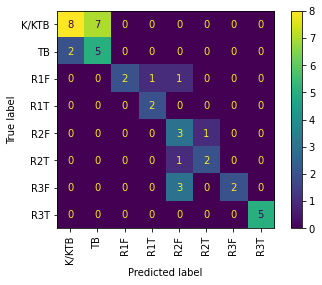

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


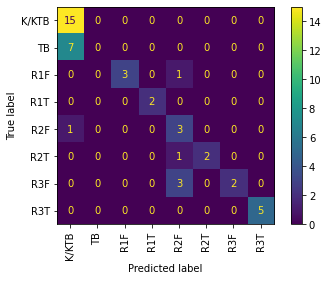

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


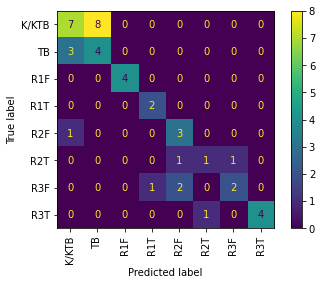

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


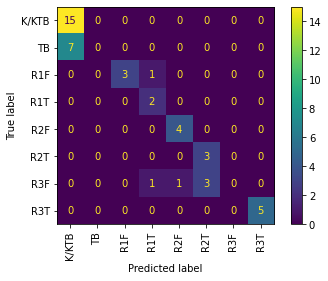

gyroscope
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Columns: 126 entries, 0 to labels
dtypes: float64(124), int64(1), object(1)
memory usage: 177.3+ KB
             0          1          2          3          4          5  \
0     7.367971   7.979637   9.333076  11.897513  16.592292  23.342798   
1     7.497099   8.341564  10.883840  14.131055  19.354216  25.249332   
2     6.632917   7.916274  10.075992  13.404463  20.106796  28.228363   
3     6.931857   7.446463   8.999518  11.530684  15.870709  23.178806   
4     5.329020   5.692592   7.976280  11.000047  15.749672  24.136668   
..         ...        ...        ...        ...        ...        ...   
175  11.758750  14.295012  18.724515  24.836820  33.124925  38.228187   
176   9.196407  10.141962  12.427213  16.869831  21.813678  26.916182   
177   9.284986   9.719061  12.041137  16.070953  20.640136  28.136830   
178  11.115941  13.384564  17.015567  22.065090  29.148329  35.818381   
179   9.915274 

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklea

ACCURACY
Naive bayes: 0.7592592592592593
SVM VECTORS: 0.7962962962962963
DECISION TREE: 0.5555555555555556
RANDOM FOREST: 0.7777777777777778


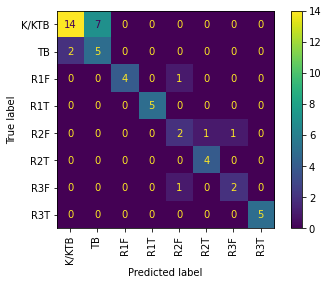

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


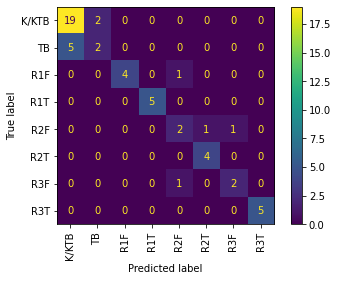

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


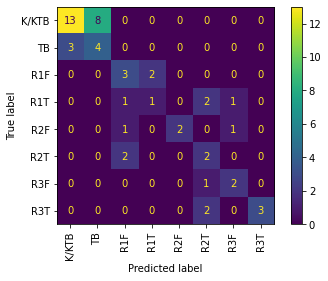

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


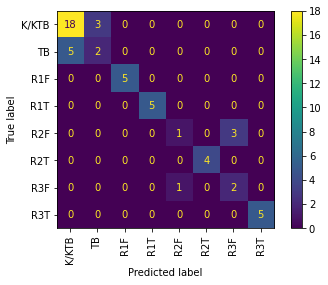

Enter your email account password: ayzl iwoa stlf lwzy


In [ ]:
accelerometer_algorithm(30,0,0,0,0,0,0,0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   0              168 non-null    float64
 1   1              168 non-null    float64
 2   2              168 non-null    float64
 3   3              168 non-null    float64
 4   4              168 non-null    float64
 5   5              168 non-null    float64
 6   6              168 non-null    float64
 7   7              168 non-null    float64
 8   8              168 non-null    float64
 9   9              168 non-null    float64
 10  10             168 non-null    float64
 11  11             168 non-null    float64
 12  12             168 non-null    float64
 13  13             168 non-null    float64
 14  14             168 non-null    float64
 15  15             168 non-null    float64
 16  16             168 non-null    float64
 17  17             168 non-null    float64
 18  18        

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklea

ACCURACY
Naive bayes: 0.375
SVM VECTORS: 0.4166666666666667
DECISION TREE: 0.5
RANDOM FOREST: 0.5


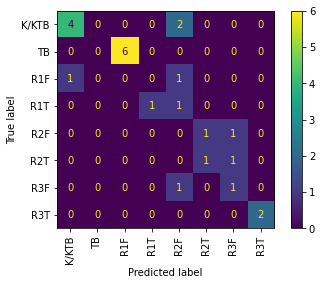

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


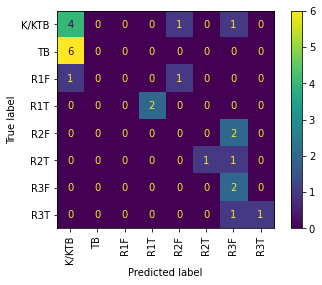

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


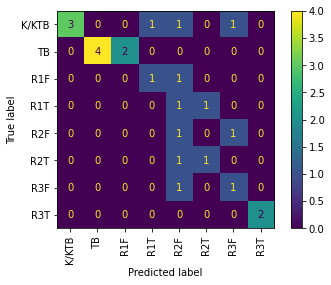

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


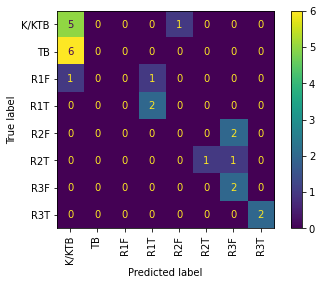

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Columns: 166 entries, 0 to labels
dtypes: float64(165), object(1)
memory usage: 429.4+ KB
PO NORMALIZACJI
            0         1         2         3         4         5         6  \
0    0.121246  0.096023  0.143458  0.134740  0.129822  0.123628  0.176016   
1    0.123436  0.100521  0.145987  0.134741  0.132195  0.125808  0.184081   
2    0.125254  0.096666  0.139855  0.121887  0.113289  0.111215  0.174604   
3    0.154191  0.113188  0.157483  0.139868  0.126868  0.116263  0.164135   
4    0.142993  0.099655  0.129467  0.106747  0.097915  0.089197  0.125051   
..        ...       ...       ...       ...       ...       ...       ...   
326  0.019085  0.013996  0.017409  0.018843  0.018777  0.017551  0.025688   
327  0.021360  0.018872  0.028857  0.026321  0.024711  0.022922  0.032481   
328  0.031739  0.042339  0.098427  0.078537  0.066456  0.053616  0.060540   
329  0.004159  0.004659  0.010410  0.013351  0.01445

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklea

ACCURACY
Naive bayes: 0.375
SVM VECTORS: 0.25
DECISION TREE: 0.375
RANDOM FOREST: 0.5


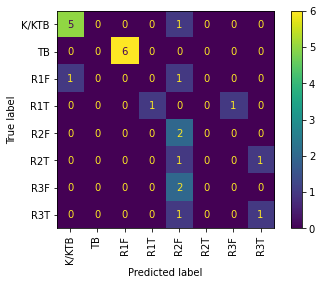

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


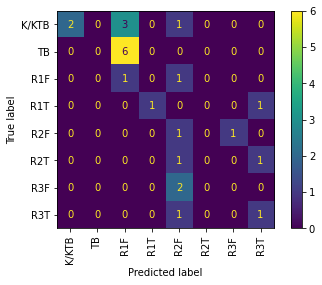

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


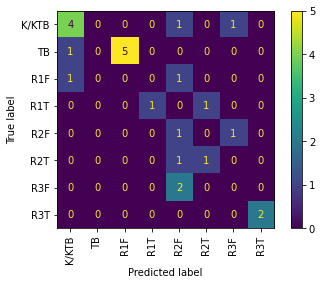

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


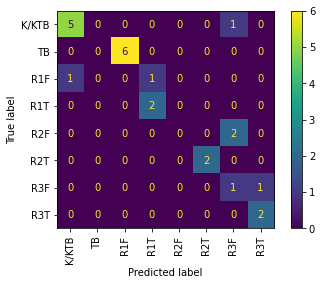

Enter your email account password: ayzl iwoa stlf lwzy


In [ ]:
accelerometer_algorithm_act(40,0,0,0,0,0,0,0,[3,5,7,2,4,6,3,5,7,2,4,6])